In [ ]:
DEVICE = 'cuda:0' 
config = {
    "embedding": 32, # Node embeddings size 
    "batch": 512, # Batch size 
    "epochs": 1000, # Training 
    "target": "seconds", # sat OR seconds (classification vs regression)
    "log": False, # Whether model should be trained in log-space 
    "dataset": "cnf.csv", # File with dataset
    "layers": 3, # Number of GNN layers 
    "transformation": "relu", # Node transformation before applying GNN (relu, linear, mlp)
    "gnn": "MLPGraphNorm", # Actual graph network architecture (SAGEConv, SAGE_MLP, GINConv, MLP_GIN, GATConv, MLPGraphNorm)
    "projection": "mlp", # How to combine neighbor embeddings (linear, mlp, mlp-3)
    "readout": "multi", # How to aggregate final node embeddings (lstm, mean, sum, multi)
    "dropout": False,
    "jumping": True, # Whether apply jumping knowledge technique (sum over past values) 
    "encoding": "lcg",
    "small": False, # Use subset of training data
}

In [ ]:
from pysat.formula import CNF
from itertools import permutations 
import torch 
import pandas as pd 
from copy import deepcopy 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import numpy 

from torch_geometric.loader import DataLoader
from torch.nn import Sequential, ReLU, Linear 
import torch.nn.functional as F 

from torch_geometric.nn import MessagePassing
from torch_geometric.nn import HeteroConv, SAGEConv, GAT, GATConv, GINConv 
from torch_geometric.data import HeteroData
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.aggr import MLPAggregation, LSTMAggregation, SumAggregation, MultiAggregation 
from torch_geometric.nn.models import MLP 
from torch_geometric.utils import degree
from torch import Tensor

import torchmetrics
from torch_geometric.nn import summary 
import time 
import os 
import random 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/petek/ML/venv/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


# Dataset

In [3]:
# Read CNF file and transform to graph

In [ ]:
initial_literal_embedding = torch.ones(config['embedding'])
initial_clause_embedding = torch.ones(config['embedding'])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
def index_literal(l, n_vars):
    "Return index of the literal."
    # First go positives, then negatives. Ex. [1, 2, 3, -1, -2, -3] 
    return l-1 if l > 0 else (-l-1)+n_vars 

def lig_graph(filepath):
    # LIG encoding 
    cnf = CNF(from_file=filepath)
    n_vars = cnf.nv 
    edges = [] 
    for clause in cnf.clauses:
        for (x_i, x_j) in permutations(clause, r=2):
            x_i = index_literal(x_i, n_vars)
            x_j = index_literal(x_j, n_vars)
            edges.append((x_i, x_j))
    edges = list(set(edges)) # Remove duplicates 
    # Add links between literals of same variable
    edges.extend([(i, i+n_vars) for i in range(n_vars)])
    edges.extend([(i+n_vars, i) for i in range(n_vars)]) # Both directions 
    edges = torch.Tensor(edges).to(torch.int64).T 

    # 2 literals for each variable 
    x = initial_literal_embedding.repeat(n_vars*2, 1) # Initialize node embeddings to ones 
    
    return x, edges 

def lcg_graph(filepath):
    # LCG encoding 
    cnf = CNF(from_file=filepath)
    n_vars = cnf.nv 
    lc_edges = [] 
    cl_edges = [] 
    for i, clause in enumerate(cnf.clauses):
        for x_i in clause:
            x_i = index_literal(x_i, n_vars) 
            # Note: literals and clause has distinct indices 
            lc_edges.append((x_i, i)) 
            cl_edges.append((i, x_i)) 

    # Add links between literals of same variable
    literal_edges = [(i, i+n_vars) for i in range(n_vars)] 
    literal_edges.extend([(i+n_vars, i) for i in range(n_vars)]) # Both directions 

    lc_edges = torch.Tensor(lc_edges).to(torch.int64).T 
    cl_edges = torch.Tensor(cl_edges).to(torch.int64).T 
    literal_edges = torch.Tensor(literal_edges).to(torch.int64).T 

    # 2 literals for each variable 
    x_vars = initial_literal_embedding.repeat(n_vars*2, 1) # copy embedding for each literal 

    x_clauses = initial_clause_embedding.repeat(len(cnf.clauses), 1) # copy embedding for each literal 
    
    return (x_vars, x_clauses), (literal_edges, lc_edges, cl_edges) 

## Pre-process cnf files into graphs

SAT are 4899, UNSAT are 4899
                         filename    seconds    sat
0  formulas/3sat_200-300/1786.cnf   2.160860  False
1  formulas/3sat_200-300/7113.cnf  15.589273  False
2  formulas/3sat_200-300/1570.cnf   0.821568   True
3  formulas/3sat_200-300/2053.cnf   4.809507  False
4  formulas/3sat_200-300/5305.cnf   0.705415   True
5  formulas/3sat_200-300/9035.cnf   0.985307  False
6  formulas/3sat_200-300/6464.cnf   4.508463  False
7  formulas/3sat_200-300/4969.cnf   0.572367   True
8  formulas/3sat_200-300/7296.cnf  19.458613  False


100%|██████████| 9798/9798 [00:38<00:00, 254.80it/s]

Total dataset has 9798 graphs


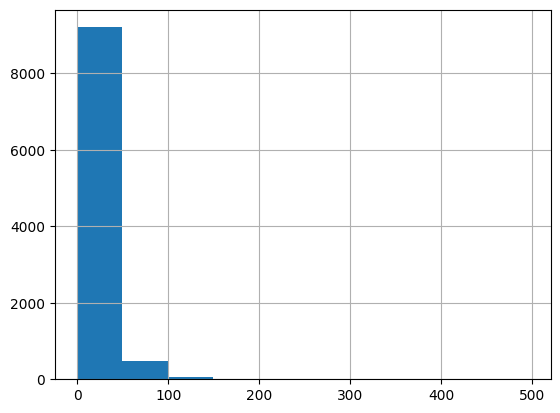

In [ ]:
formulas = pd.read_csv(config['dataset'])[['filename', 'seconds', 'sat']] 

formulas = formulas.dropna() # Take only valid data 
formulas = formulas.sample(frac=1, random_state=12345).reset_index(drop=True) # Random permutation 

if config['small']:
 formulas = formulas[:2000] # Choose a subset 
print(f"SAT are {sum(formulas['sat'] == True)}, UNSAT are {sum(formulas['sat'] == False)}")


if config['log']:
    formulas['seconds'] = numpy.log(formulas['seconds'])  # log10
formulas['seconds'].hist() # bins=[0, 10, 100, 500]


mapping = {} 
dataset = [] 
batches = [] 
current_batch = [] 
for i, (file, seconds, sat) in enumerate(tqdm(formulas.values)):  
    x, edges = lcg_graph(file) 
    data = HeteroData() 
    # Add node features 
    data['literals'].x = x[0] 
    data['clauses'].x = x[1] 
    # Add edges 
    data['literals', 'negates', 'literals'].edge_index = edges[0] 
    data['literals', 'inside', 'clauses'].edge_index = edges[1] 
    data['clauses', 'contains', 'literals'].edge_index = edges[2] 
    # Add graph label 
    if config['target'] == "sat":
        data.y = float(sat) 
    else:
        data.y = seconds 
    data.validate() # Throw error if graph is not valid 
    dataset.append(data) 
    mapping[i] = file 
print(f"Total dataset has {len(dataset)} graphs") 

# GNN model class

In [12]:
class MLPGraphConv(MessagePassing):
    def __init__(self, mlp, aggr='mean'):
        super().__init__(aggr=aggr)  # Aggregation can be 'mean', 'add', or 'max'
        # Define the MLP
        self.mlp = mlp 

    def forward(self, x, edge_index):
        # Perform message passing
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # Apply the MLP to the source node features
        return self.mlp(x_j)


class SAGE_MLP(SAGEConv):
    # Only apply MLP on node embedddings before message propagation 
    def __init__(self, mlp, *args, **kwargs):
        super().__init__(*args, **kwargs) 
        # Define the MLP
        self.mlp = deepcopy(mlp) 

    def message(self, x_j):
        # Apply the MLP to the source node features
        return self.mlp(x_j)


# With normalization 
class MLPGraphNorm(MessagePassing):
    def __init__(self, mlp, aggr='mean'):
        super(MLPGraphNorm, self).__init__(aggr=aggr)  # Aggregation can be 'mean', 'add', or 'max'
        # Define the MLP
        self.mlp = mlp

    def forward(self, x, edge_index):
        """
        Args:
            x: Node feature matrix or a tuple (x_src, x_dst) for bipartite graphs.
            edge_index: Edge index tensor.
        """
        if isinstance(x, tuple):
            x_src, x_dst = x
        elif isinstance(x, torch.Tensor):
            x_src = x_dst = x
        else:
            print("HERE", "STRANDE")
            print(type(x)) 
            print(x, x.shape)
            print(stange)

        # Number of source and target nodes
        num_src, num_dst = x_src.size(0), x_dst.size(0)
        
        # Compute degree for source nodes (row normalization)
        row, col = edge_index
        deg_src = degree(row, num_src, dtype=x_src.dtype)
        deg_inv_sqrt_src = deg_src.pow(-0.5)
        deg_inv_sqrt_src[deg_inv_sqrt_src == float('inf')] = 0

        # Compute degree for target nodes (col normalization)
        deg_dst = degree(col, num_dst, dtype=x_dst.dtype)
        deg_inv_sqrt_dst = deg_dst.pow(-0.5)
        deg_inv_sqrt_dst[deg_inv_sqrt_dst == float('inf')] = 0

        # Perform message passing
        return self.propagate(edge_index, x=(x_src, x_dst), 
                              deg_inv_sqrt_src=deg_inv_sqrt_src, 
                              deg_inv_sqrt_dst=deg_inv_sqrt_dst)

    def message(self, x_j, edge_index, deg_inv_sqrt_src, deg_inv_sqrt_dst):
        """
        Args:
            x_j: Features of source nodes.
            edge_index: Edge index tensor.
            deg_inv_sqrt_src: Normalization factor for source nodes.
            deg_inv_sqrt_dst: Normalization factor for target nodes.
        """
        row, col = edge_index
        norm = deg_inv_sqrt_src[row] * deg_inv_sqrt_dst[col]
        return norm.view(-1, 1) * self.mlp(x_j)

class MLP_GIN(GINConv):
    # Just GIN with MLP applied before message aggregation 
    def __init__(self, mlp, **kwargs):
        super().__init__(**kwargs)
        self.mlp = mlp 
    def message(self, x_j: Tensor) -> Tensor:
        return self.mlp(x_j) 

In [ ]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        
        # Define convolution layers for each edge type
        self.convs = torch.nn.ModuleList() 
        for i in range(config['layers']):
            assert config['embedding'] == hidden_dim 

            match config['transformation']:
                case "relu":
                    node_mlp = Sequential(
                        Linear(hidden_dim, hidden_dim),
                        ReLU(),
                        Linear(hidden_dim, hidden_dim)
                    )
                case "linear":
                    node_mlp = Linear(hidden_dim, hidden_dim)
                case "mlp":
                    node_mlp = MLP(in_channels=hidden_dim, hidden_channels=hidden_dim, out_channels=hidden_dim, num_layers=3)  
                case _:
                    print(f"ERROR: '{config['transformation']}' is not defined as transformation operation.")
                    exit(1)
            
            # Used for GIN-based convolution 
            gin_nn = Sequential(
                Linear(hidden_dim, hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim)
            )

            match config['gnn']:
                case "SAGEConv":
                    relation_dict = {
                        ('literals', 'inside', 'clauses'): SAGEConv(config['embedding'], hidden_dim, aggr='sum', project=False),
                        ('clauses', 'contains', 'literals'): SAGEConv(config['embedding'], hidden_dim, aggr='sum', project=False),
                        ('literals', 'negates', 'literals'): SAGEConv(config['embedding'], hidden_dim, aggr='sum', project=False),
                    }
                case "SAGE_MLP":
                    relation_dict = {
                        ('literals', 'inside', 'clauses'): SAGE_MLP(node_mlp, config['embedding'], hidden_dim, aggr='mean', project=False),
                        ('clauses', 'contains', 'literals'): SAGE_MLP(node_mlp, config['embedding'], hidden_dim, aggr='mean', project=False),
                        ('literals', 'negates', 'literals'): SAGE_MLP(node_mlp, config['embedding'], hidden_dim, aggr='mean', project=False),
                    }
                case "MLPGraphNorm":
                    relation_dict = {
                        ('literals', 'inside', 'clauses'): MLPGraphNorm(node_mlp, aggr='sum'),
                        ('clauses', 'contains', 'literals'): MLPGraphNorm(node_mlp, aggr='sum'),
                        ('literals', 'negates', 'literals'): MLPGraphNorm(node_mlp, aggr='sum'),
                    }
                case "MLP_GIN":
                    relation_dict = {
                        ('literals', 'inside', 'clauses'): MLP_GIN(node_mlp, nn=gin_nn, aggr='sum'),
                        ('clauses', 'contains', 'literals'): MLP_GIN(node_mlp, nn=gin_nn, aggr='sum'),
                        ('literals', 'negates', 'literals'): MLP_GIN(node_mlp, nn=gin_nn, aggr='sum'), 
                    }
                case "GINConv":
                    relation_dict = {
                        ('literals', 'inside', 'clauses'): GINConv(nn=gin_nn, aggr='sum'),
                        ('clauses', 'contains', 'literals'): GINConv(nn=gin_nn, aggr='sum'),
                        ('literals', 'negates', 'literals'): GINConv(nn=gin_nn, aggr='sum'), 
                    }
                case "GATConv":
                    relation_dict = {
                        ('literals', 'inside', 'clauses'): GATConv(config['embedding'], hidden_dim, add_self_loops=False), 
                        ('clauses', 'contains', 'literals'): GATConv(config['embedding'], hidden_dim, add_self_loops=False),
                        ('literals', 'negates', 'literals'): GATConv(config['embedding'], hidden_dim, add_self_loops=False),
                    }
                case _:
                    print(f"ERROR: '{config['gnn']}' is not defined as GNN architecture.")
                    exit(1)

            convs = HeteroConv(relation_dict, aggr='cat') # Aggregation across edge types 
            self.convs.append(convs) 

        self.literal_linears = torch.nn.ModuleList() 
        self.clause_linears = torch.nn.ModuleList() 
        for i in range(config['layers']):
            match config["projection"]:
                case "linear":
                    # Projection layers for each node type
                    literals_linear = torch.nn.Linear(2*hidden_dim, hidden_dim) # Concat of clause and opposite literal embeds 
                    clauses_linear = torch.nn.Linear(hidden_dim, hidden_dim) 
                case "mlp":
                    literals_linear = MLP([2*hidden_dim, hidden_dim, hidden_dim]) 
                    clauses_linear = MLP([hidden_dim, hidden_dim, hidden_dim]) 
                case "mlp-3":
                    literals_linear = MLP(in_channels=2*hidden_dim, hidden_channels=hidden_dim, out_channels=hidden_dim, num_layers=3) # Concat of clause and opposite literal embeds 
                    clauses_linear = MLP(in_channels=hidden_dim, hidden_channels=hidden_dim, out_channels=hidden_dim, num_layers=3)
                case _:
                    print(f"ERROR: '{config['projection']}' is not defined as projection operation.")
                    exit(1)

            self.literal_linears.append(literals_linear) 
            self.clause_linears.append(clauses_linear) 

        match config["readout"]:
            case "lstm":
                self.readout = LSTMAggregation(hidden_dim, hidden_dim, num_layers=3) 
            case "mean":
                self.readout = global_mean_pool 
            case "sum":
                self.readout = SumAggregation() 
            case "multi":
                self.readout = MultiAggregation(['sum', 'mean'], mode='cat') # cat is default mode
            case _:
                print(f"ERROR: '{config['readout']}' is not defined as readout operation.")
                exit(1)

        if config['target'] == "sat":
            # SAT classification 
            self.classifier = MLP(in_channels=-1, hidden_channels=hidden_dim, out_channels=1, num_layers=2) 
        else:
            self.regressor = MLP(in_channels=-1, hidden_channels=hidden_dim, out_channels=1, num_layers=2) 

    def forward(self, data):
        # HeteroConv expects node features and edge_index as a dictionary
        x_dict = data.x_dict
        edge_index_dict = data.edge_index_dict

        # Apply heterogeneous message passing
        jumping_literals = torch.zeros(x_dict['literals'].shape).to(x_dict['literals'].device) 
        jumping_clauses = torch.zeros(x_dict['clauses'].shape).to(x_dict['clauses'].device) 
        for conv, literal_linear, clause_linear in zip(self.convs, self.literal_linears, self.clause_linears):
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: x.relu() for key, x in x_dict.items()} 
            # Apply transformations for each node type
            x_dict['literals'] = literal_linear(x_dict['literals'])
            x_dict['clauses'] = clause_linear(x_dict['clauses'])

            jumping_literals += x_dict['literals'] 
            jumping_clauses += x_dict['clauses'] 


        # Readout operation: Aggregate the node features of both 'literals' and 'clauses'
        # We'll aggregate over all nodes of the graph
        if config['jumping']:
            x_graph = torch.cat([self.readout(jumping_literals, data.batch['literals']), self.readout(jumping_clauses, data.batch['clauses'])], 1)
        else:
            x_graph = torch.cat([self.readout(x_dict['literals'], data.batch['literals']), self.readout(x_dict['clauses'], data.batch['clauses'])], 1)
        
        if config['target'] == "sat":
            if config['dropout']:
                x_graph = F.dropout(x_graph, p=0.5, training=self.training) 
            res = torch.sigmoid(self.classifier(x_graph))
        else:            
            # Apply a final regressor
            if config['dropout']:
                x_graph = F.dropout(x_graph, p=0.5, training=self.training) # Dropout to avoid overfit
            res = self.regressor(x_graph) 

        return res 

# Training

In [15]:
test_split = len(dataset)*8//10 
# Create a DataLoader for batching
train_loader = DataLoader(dataset[:test_split], batch_size=config['batch'], shuffle=False) 
test_loader = DataLoader(dataset[test_split:], batch_size=config['batch'], shuffle=False) 

print(len(train_loader), len(test_loader))

16 4


In [16]:
def compute_batch_assignment(batch, node_type):
    """
    Given a batch of graphs in a HeteroDataBatch, extract the '.ptr' and compute the 'batch' tensor that assigns each node to its graph based on the '.ptr' values.
    
    Args:
        batch (HeteroDataBatch): A batch containing multiple graphs.
    
    Returns:
        batch_tensor (Tensor): A tensor of size (total number of nodes across all graphs, ) containing the graph index for each node.
    """
    # Initialize an empty list to collect the batch indices for each graph
    batch_tensor = []
    
    # Access the 'ptr' for each graph type in the batch (should be present in the batch)
    # Get the prefix sum (ptr) tensor
    ptr = batch[node_type].ptr
    
    # Loop over each graph in the batch (using ptr values)
    for i in range(len(ptr) - 1):
        # Assign the same batch index for each node in the current graph
        batch_tensor.extend([i] * (ptr[i + 1] - ptr[i]))
    
    # Convert the list to a tensor
    return torch.tensor(batch_tensor, dtype=torch.long)



In [ ]:
def train():
    model.train()

    for batch in train_loader:  # Iterate in batches over the training dataset.
        batch.batch = {'literals': compute_batch_assignment(batch, 'literals'), 'clauses': compute_batch_assignment(batch, 'clauses')} 
        batch = batch.to(DEVICE) 
        out = model(batch).squeeze()  # Perform a single forward pass. 
        loss = criterion(out, batch.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        # Perform gradient clipping by value
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=5.) 
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.



def test(loader):
    model.eval()

    total_out = [] 
    total_y = [] 
    with torch.no_grad():
        for batch in loader:
            batch.batch = {'literals': compute_batch_assignment(batch, 'literals'), 'clauses': compute_batch_assignment(batch, 'clauses')} 
            batch = batch.to(DEVICE) 
            out = model(batch).squeeze() 
            total_out.append(out) 
            total_y.append(batch.y) 

    total_out = torch.cat(total_out, 0)
    total_y = torch.cat(total_y, 0)

    return total_out, total_y 

def compute_main_metric(out, y):
    total_loss = criterion(out, y) 
    return total_loss 

def compute_metrics(out, y):
    metrics = {} 
    if config['target'] == "sat": 
        metrics['Entropy'] = torch.nn.functional.binary_cross_entropy(out, y) 
        metrics['Accuracy'] = (torch.round(out) == y).sum() / len(out) # Count correct predictions 
    else: 
        metrics['MSE'] = torch.nn.functional.mse_loss(out, y) 
        metrics['L1'] = torch.nn.functional.l1_loss(out, y) 
        metrics['R2'] = torchmetrics.functional.r2_score(out, y) 
        metrics['MAPE'] = torchmetrics.functional.mean_absolute_percentage_error(out, y) 
        metrics['Spearman'] = torchmetrics.functional.spearman_corrcoef(out, y) 

    return metrics 

def plot_predictions(out, y, title='Test data', file=None):
    if config['target'] == "sat":
        # Confusion matrix
        disp = ConfusionMatrixDisplay.from_predictions(y.cpu(), out.cpu() > 0.5, normalize='true', display_labels=['UNSAT', 'SAT'], cmap=plt.cm.Blues)
        plt.title(title)
        if file:
            plt.savefig(file)
        else:
            plt.show() 
        
    else:
        # Regression task 
        fig, ax = plt.subplots(figsize=(5, 5)) 
        preds = out.cpu() 
        reals = y.cpu() 

        ax.set_xlim((0, 500.)) 
        ax.set_ylim((0, 500.))
        ax.set_aspect("equal")

        ax.set_title(title)
        ax.set_ylabel("Predictions")
        ax.set_xlabel("Real times")
        ax.scatter(reals, preds, s=2, color='blue', label='Model outputs') 
        ax.axline((0, 0), slope=1., color='red', label='Perfect') 
        ax.grid()
        ax.legend() 
        if file:
            plt.savefig(file)
        else:
            plt.show() 

In [18]:
model = HeteroGNN(hidden_dim=config['embedding']).to(DEVICE) 
for batch in train_loader:
    batch.batch = {'literals': compute_batch_assignment(batch, 'literals'), 'clauses': compute_batch_assignment(batch, 'clauses')} 
    batch = batch.to(DEVICE)
    print(summary(model, batch, max_depth=6)) 
    break 

+----------------------------------------------------------------+---------------------------+----------------------+----------+
| Layer                                                          | Input Shape               | Output Shape         | #Param   |
|----------------------------------------------------------------+---------------------------+----------------------+----------|
| HeteroGNN                                                      | [806299, 806299]          | [512, 1]             | -1       |
| ├─(convs)ModuleList                                            | --                        | --                   | 6,336    |
| │    └─(0)HeteroConv                                           |                           |                      | 2,112    |
| │    │    └─(convs)ModuleDict                                  | --                        | --                   | 2,112    |
| │    │    │    └─(<literals___inside___clauses>)MLPGraphNorm   | [2, 1646319]              | [5

### Main loop

HeteroGNN(
  (convs): ModuleList(
    (0-2): 3 x HeteroConv(num_relations=3)
  )
  (literal_linears): ModuleList(
    (0-2): 3 x MLP(64, 32, 32)
  )
  (clause_linears): ModuleList(
    (0-2): 3 x MLP(32, 32, 32)
  )
  (readout): MultiAggregation([
    SumAggregation(),
    MeanAggregation(),
  ], mode=cat)
  (regressor): MLP(-1, 32, 1)
)
Test MSE = 829.9439697265625
Test L1 = 12.4346923828125
Test R2 = -0.24165380001068115
Test MAPE = 14.379473686218262
Test Spearman = -0.5760966539382935


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

New best: 001, Train Loss: 794.634338
Test MSE = 883.2980346679688
Test L1 = 14.872003555297852
Test R2 = -0.3214752674102783
Test MAPE = 29.895099639892578
Test Spearman = 0.5767192840576172


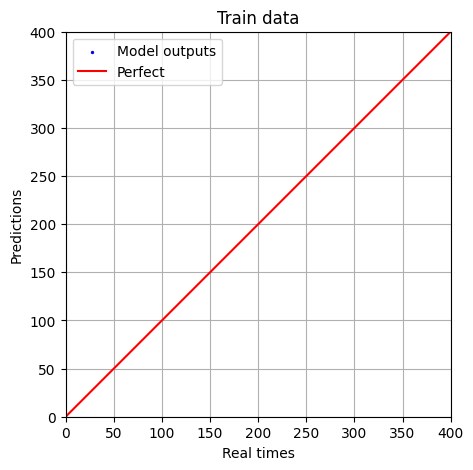

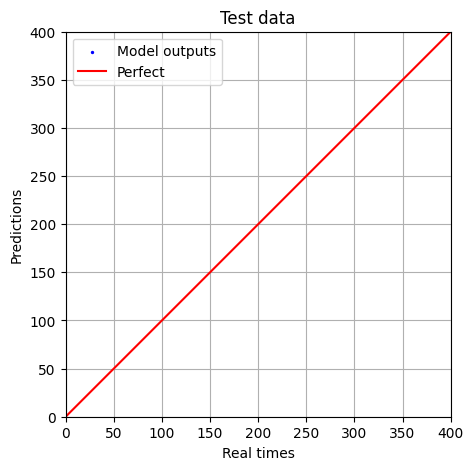

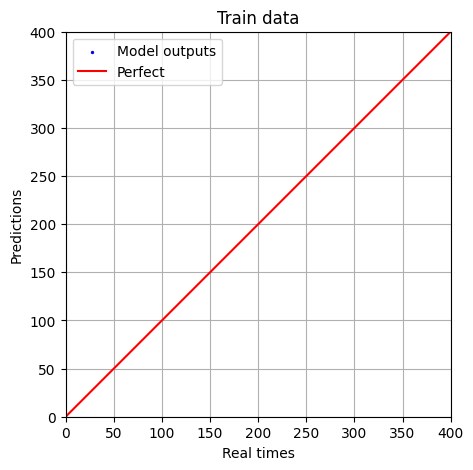

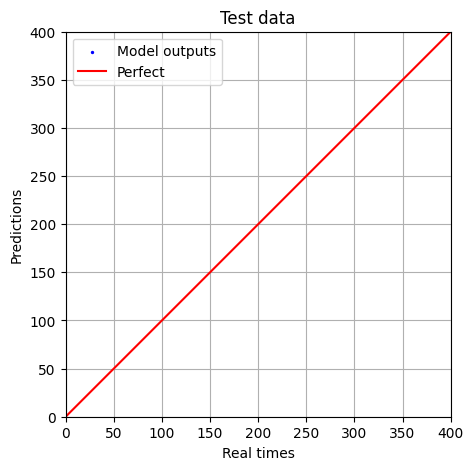

Epochs:   0%|          | 1/1000 [00:10<3:00:06, 10.82s/it]


New best: 002, Train Loss: 775.378296
Test MSE = 863.7212524414062
Test L1 = 14.228816032409668
Test R2 = -0.292186975479126
Test MAPE = 26.765695571899414
Test Spearman = 0.5746966600418091


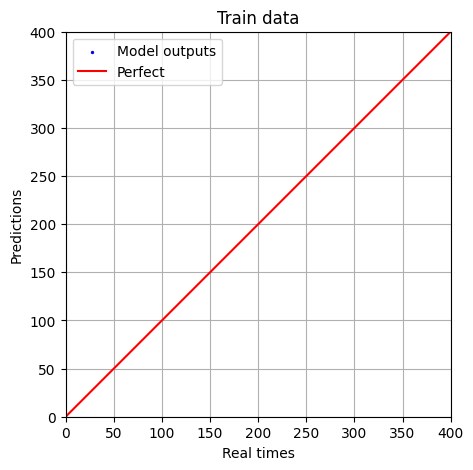

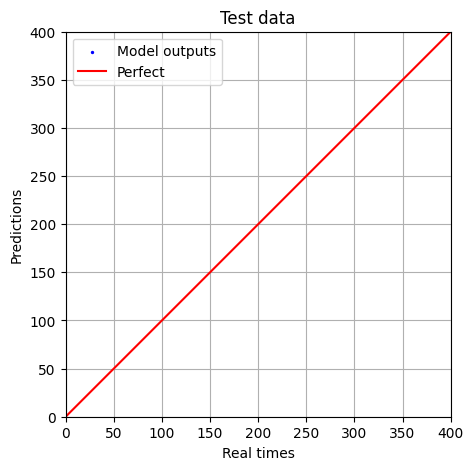

Epochs:   0%|          | 2/1000 [00:21<2:55:23, 10.54s/it]


New best: 003, Train Loss: 738.277344
Test MSE = 825.9556884765625
Test L1 = 12.935822486877441
Test R2 = -0.23568713665008545
Test MAPE = 20.661497116088867
Test Spearman = 0.5791587233543396


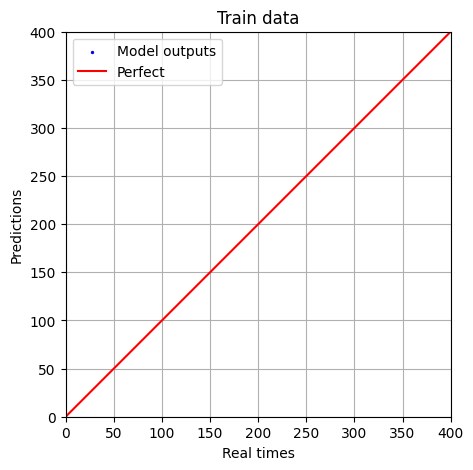

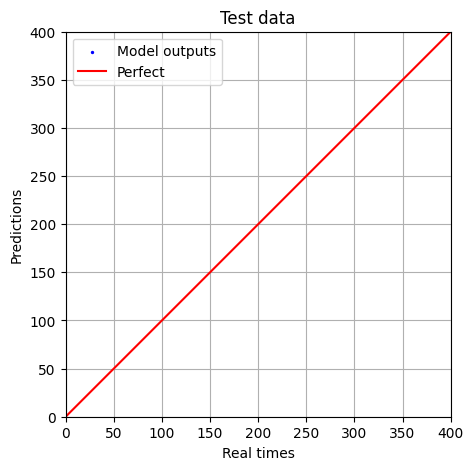

Epochs:   0%|          | 3/1000 [00:31<2:53:01, 10.41s/it]


New best: 004, Train Loss: 659.405457
Test MSE = 745.4387817382812
Test L1 = 10.13689136505127
Test R2 = -0.11522829532623291
Test MAPE = 8.940206527709961
Test Spearman = 0.6044279336929321


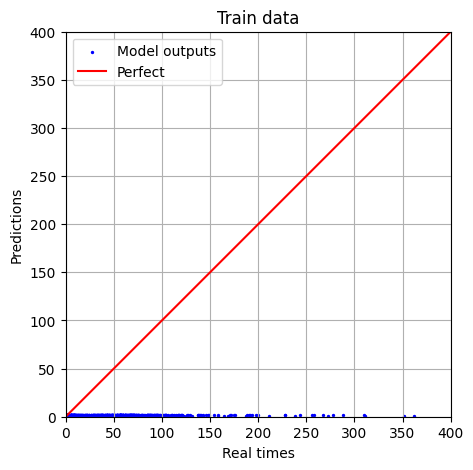

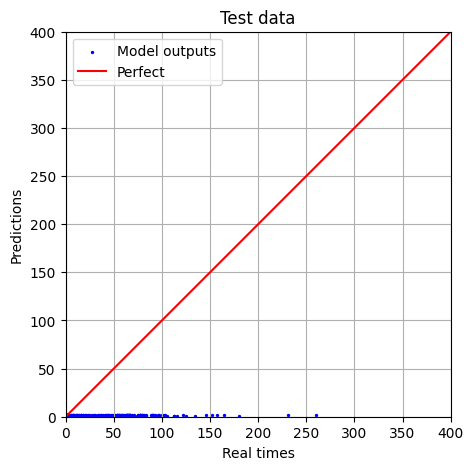

Epochs:   0%|          | 4/1000 [00:41<2:53:36, 10.46s/it]


New best: 005, Train Loss: 560.180237
Test MSE = 644.053955078125
Test L1 = 8.505629539489746
Test R2 = 0.03645056486129761
Test MAPE = 6.304309368133545
Test Spearman = 0.640425980091095


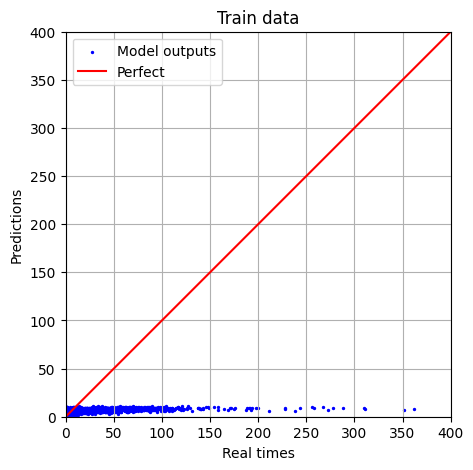

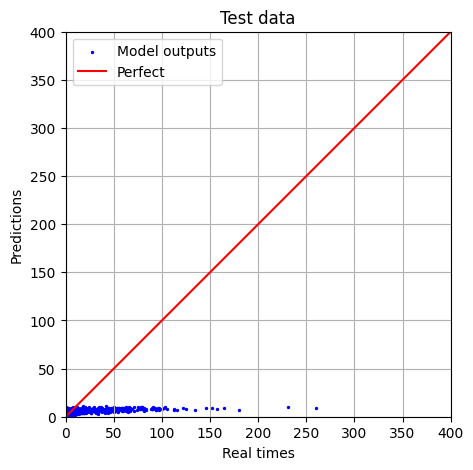

Epochs:   0%|          | 5/1000 [00:52<2:52:51, 10.42s/it]


New best: 006, Train Loss: 498.703522
Test MSE = 581.5677490234375
Test L1 = 11.805699348449707
Test R2 = 0.1299341917037964
Test MAPE = 28.724313735961914
Test Spearman = 0.655403196811676


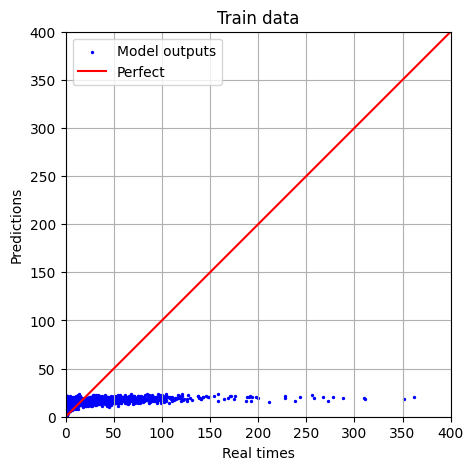

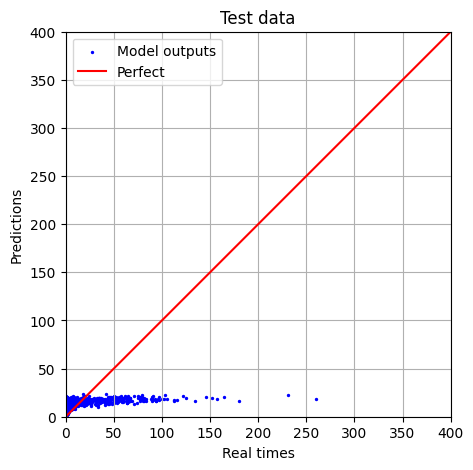

Epochs:   1%|          | 6/1000 [01:02<2:53:24, 10.47s/it]

Epochs:   1%|          | 8/1000 [01:20<2:39:56,  9.67s/it]

New best: 009, Train Loss: 485.788574
Test MSE = 568.5698852539062
Test L1 = 11.766532897949219
Test R2 = 0.14937996864318848
Test MAPE = 29.419517517089844
Test Spearman = 0.6401336789131165


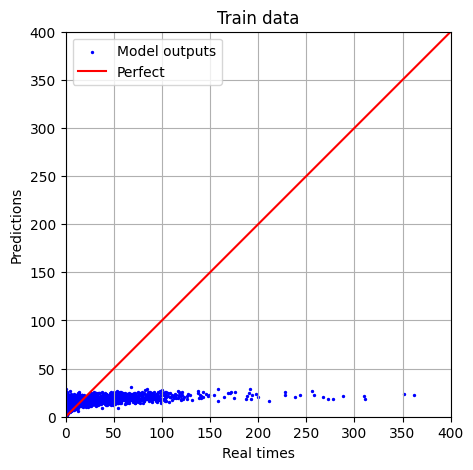

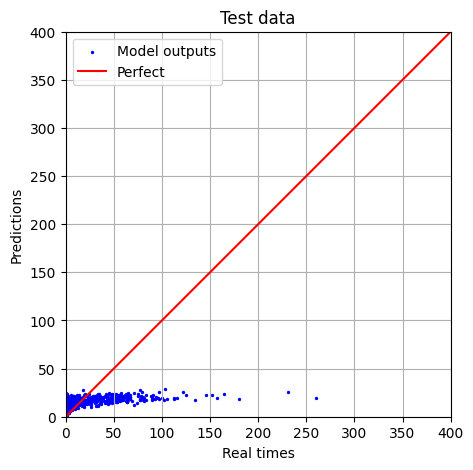

Epochs:   1%|          | 9/1000 [01:31<2:43:48,  9.92s/it]

Epochs:   1%|          | 10/1000 [01:41<2:45:34, 10.03s/it]

Train Loss: 721.544922
Test MSE = 808.997802734375
Test L1 = 11.820258140563965
Test R2 = -0.21031689643859863
Test MAPE = 12.515467643737793
Test Spearman = -0.2709444761276245
--------------------------------------------------------------------------------


Epochs:   2%|▏         | 17/1000 [02:46<2:33:15,  9.35s/it]

New best: 018, Train Loss: 466.634979
Test MSE = 554.1640625
Test L1 = 13.604399681091309
Test R2 = 0.17093205451965332
Test MAPE = 33.851104736328125
Test Spearman = 0.6573352217674255


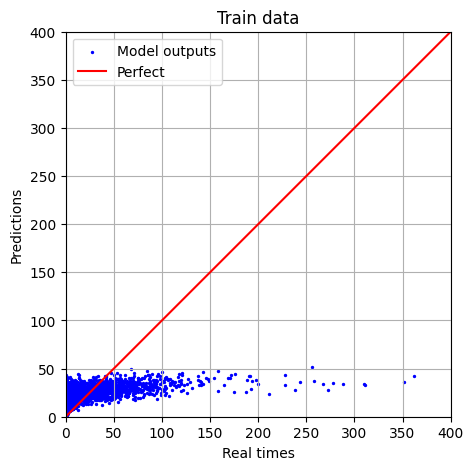

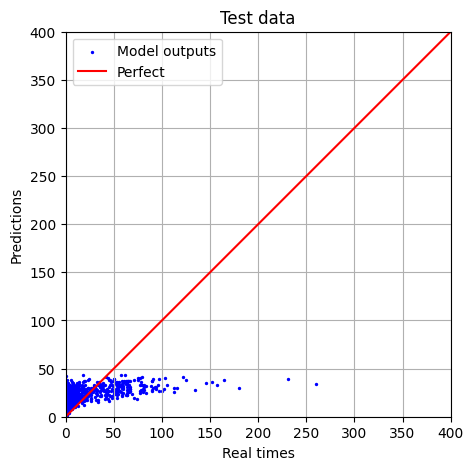

Epochs:   2%|▏         | 18/1000 [02:57<2:39:24,  9.74s/it]


New best: 019, Train Loss: 458.882782
Test MSE = 540.9003295898438
Test L1 = 10.916243553161621
Test R2 = 0.19077545404434204
Test MAPE = 24.613008499145508
Test Spearman = 0.6311013102531433


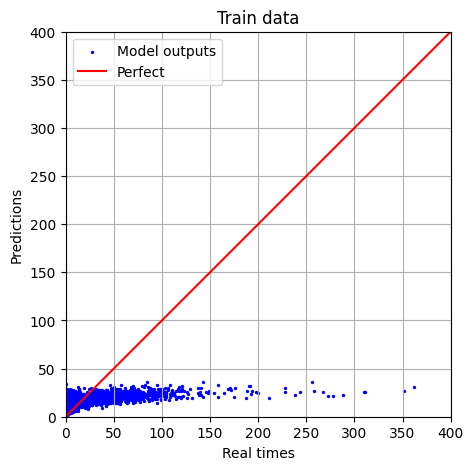

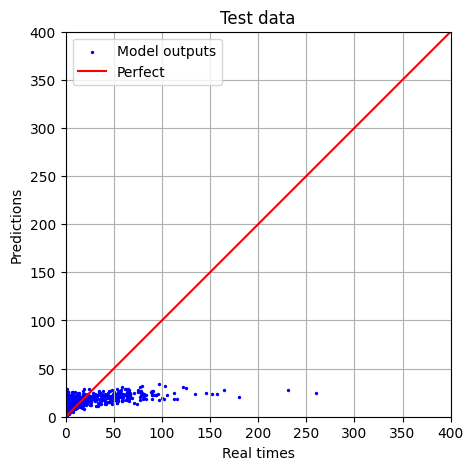

Epochs:   2%|▏         | 19/1000 [03:08<2:43:37, 10.01s/it]

Epochs:   2%|▏         | 20/1000 [03:18<2:45:43, 10.15s/it]

Train Loss: 461.124359
Test MSE = 542.240234375
Test L1 = 11.299878120422363
Test R2 = 0.18877094984054565
Test MAPE = 24.02373695373535
Test Spearman = 0.659451425075531
--------------------------------------------------------------------------------


Epochs:   3%|▎         | 30/1000 [04:52<2:35:15,  9.60s/it]

Train Loss: 634.359741
Test MSE = 719.3495483398438
Test L1 = 9.29304027557373
Test R2 = -0.07619690895080566
Test MAPE = 10.78543758392334
Test Spearman = 0.30683958530426025
--------------------------------------------------------------------------------


Epochs:   4%|▍         | 40/1000 [06:26<2:33:55,  9.62s/it]

Train Loss: 30774.275391
Test MSE = 31315.490234375
Test L1 = 169.2388916015625
Test R2 = -45.85015106201172
Test MAPE = 686.656982421875
Test Spearman = 0.5201738476753235
--------------------------------------------------------------------------------


Epochs:   5%|▌         | 50/1000 [07:59<2:31:26,  9.56s/it]

Train Loss: 52198.390625
Test MSE = 52827.25
Test L1 = 224.94769287109375
Test R2 = -78.03324127197266
Test MAPE = 965.075439453125
Test Spearman = 0.5839535593986511
--------------------------------------------------------------------------------


Epochs:   6%|▌         | 60/1000 [09:33<2:30:40,  9.62s/it]

Train Loss: 700.115356
Test MSE = 786.8438720703125
Test L1 = 10.7600736618042
Test R2 = -0.17717301845550537
Test MAPE = 13.835902214050293
Test Spearman = -0.4150816798210144
--------------------------------------------------------------------------------


Epochs:   7%|▋         | 70/1000 [11:07<2:29:36,  9.65s/it]

Train Loss: 615.280884
Test MSE = 694.1683349609375
Test L1 = 10.295366287231445
Test R2 = -0.03852403163909912
Test MAPE = 24.50282096862793
Test Spearman = 0.017708834260702133
--------------------------------------------------------------------------------


Epochs:   8%|▊         | 80/1000 [12:42<2:28:52,  9.71s/it]

Train Loss: 22724.853516
Test MSE = 23184.50390625
Test L1 = 143.5791778564453
Test R2 = -33.68562698364258
Test MAPE = 578.1417846679688
Test Spearman = 0.47459250688552856
--------------------------------------------------------------------------------


Epochs:   9%|▉         | 90/1000 [14:18<2:28:00,  9.76s/it]

Train Loss: 558.628235
Test MSE = 647.8336791992188
Test L1 = 16.389711380004883
Test R2 = 0.030795753002166748
Test MAPE = 63.929237365722656
Test Spearman = 0.5186467170715332
--------------------------------------------------------------------------------


Epochs:  10%|█         | 100/1000 [15:53<2:27:22,  9.83s/it]

Train Loss: 17966.365234
Test MSE = 18794.9140625
Test L1 = 130.35865783691406
Test R2 = -27.11849594116211
Test MAPE = 487.3076171875
Test Spearman = 0.5895147323608398
--------------------------------------------------------------------------------


Epochs:  11%|█         | 110/1000 [17:27<2:24:01,  9.71s/it]

Train Loss: 41361.808594
Test MSE = 42106.91015625
Test L1 = 199.59571838378906
Test R2 = -61.9948616027832
Test MAPE = 837.8318481445312
Test Spearman = 0.5876343846321106
--------------------------------------------------------------------------------


Epochs:  11%|█▏        | 113/1000 [17:55<2:19:13,  9.42s/it]

New best: 114, Train Loss: 410.515198
Test MSE = 633.7976684570312
Test L1 = 14.356493949890137
Test R2 = 0.05179464817047119
Test MAPE = 33.878379821777344
Test Spearman = 0.49493208527565


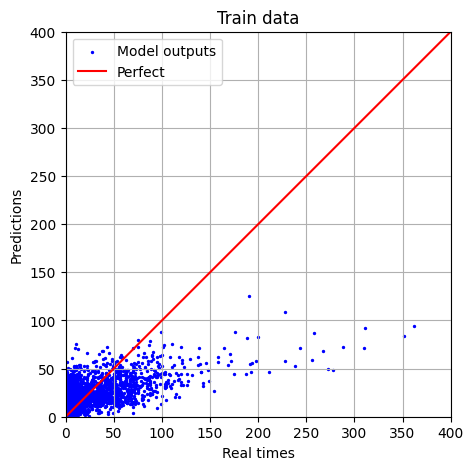

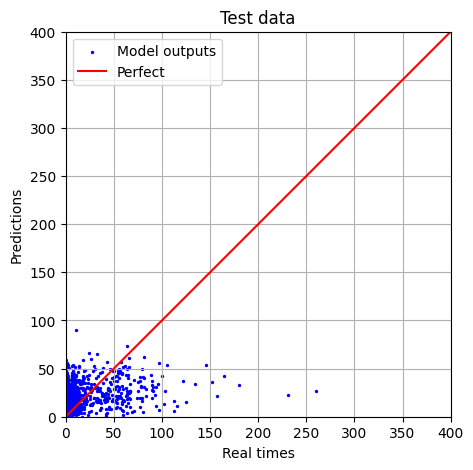

Epochs:  11%|█▏        | 114/1000 [18:06<2:24:38,  9.79s/it]

Epochs:  12%|█▏        | 120/1000 [19:02<2:20:16,  9.56s/it]

Train Loss: 436.789795
Test MSE = 603.7175903320312
Test L1 = 11.993849754333496
Test R2 = 0.09679657220840454
Test MAPE = 43.43508529663086
Test Spearman = 0.4504320025444031
--------------------------------------------------------------------------------


Epochs:  13%|█▎        | 130/1000 [20:35<2:17:22,  9.47s/it]

Train Loss: 2005.778076
Test MSE = 2059.588134765625
Test L1 = 41.691349029541016
Test R2 = -2.081286907196045
Test MAPE = 239.46124267578125
Test Spearman = -0.034132037311792374
--------------------------------------------------------------------------------


Epochs:  14%|█▍        | 140/1000 [22:09<2:19:11,  9.71s/it]

Train Loss: 19345.621094
Test MSE = 20265.62109375
Test L1 = 132.96913146972656
Test R2 = -29.31877899169922
Test MAPE = 475.1057434082031
Test Spearman = 0.5901543498039246
--------------------------------------------------------------------------------


Epochs:  15%|█▌        | 150/1000 [23:42<2:14:27,  9.49s/it]

Train Loss: 1864.416992
Test MSE = 1910.9122314453125
Test L1 = 40.147647857666016
Test R2 = -1.8588576316833496
Test MAPE = 221.80995178222656
Test Spearman = 0.2443709671497345
--------------------------------------------------------------------------------


Epochs:  16%|█▌        | 160/1000 [25:15<2:11:43,  9.41s/it]

Train Loss: 1074.929077
Test MSE = 1343.8629150390625
Test L1 = 27.08485984802246
Test R2 = -1.010512351989746
Test MAPE = 91.26160430908203
Test Spearman = 0.5112112760543823
--------------------------------------------------------------------------------


Epochs:  17%|█▋        | 170/1000 [26:48<2:12:04,  9.55s/it]

Train Loss: 6464.255371
Test MSE = 6479.3662109375
Test L1 = 78.05276489257812
Test R2 = -8.693581581115723
Test MAPE = 420.7640075683594
Test Spearman = 0.3241294324398041
--------------------------------------------------------------------------------


Epochs:  18%|█▊        | 180/1000 [28:22<2:11:42,  9.64s/it]

Train Loss: 2061638.375000
Test MSE = 2078987.625
Test L1 = 1427.0723876953125
Test R2 = -3109.31005859375
Test MAPE = 6466.04345703125
Test Spearman = 0.5731834769248962
--------------------------------------------------------------------------------


Epochs:  19%|█▉        | 190/1000 [29:55<2:09:10,  9.57s/it]

Train Loss: 107467.351562
Test MSE = 110380.6640625
Test L1 = 318.94183349609375
Test R2 = -164.13714599609375
Test MAPE = 1238.8326416015625
Test Spearman = 0.5485560297966003
--------------------------------------------------------------------------------


Epochs:  20%|██        | 200/1000 [31:28<2:07:37,  9.57s/it]

Train Loss: 7772.797852
Test MSE = 7997.62646484375
Test L1 = 86.41364288330078
Test R2 = -10.965004920959473
Test MAPE = 388.9785461425781
Test Spearman = 0.6105173826217651
--------------------------------------------------------------------------------


Epochs:  21%|██        | 210/1000 [33:04<2:08:30,  9.76s/it]

Train Loss: 26121.011719
Test MSE = 26676.001953125
Test L1 = 155.26943969726562
Test R2 = -38.90915298461914
Test MAPE = 625.1409301757812
Test Spearman = 0.5628566145896912
--------------------------------------------------------------------------------


Epochs:  22%|██▏       | 220/1000 [34:36<2:03:58,  9.54s/it]

Train Loss: 10198.009766
Test MSE = 10315.033203125
Test L1 = 99.81340789794922
Test R2 = -14.4320068359375
Test MAPE = 476.7120056152344
Test Spearman = 0.6273629069328308
--------------------------------------------------------------------------------


Epochs:  23%|██▎       | 230/1000 [36:10<2:03:03,  9.59s/it]

Train Loss: 12517.318359
Test MSE = 12907.02734375
Test L1 = 105.17843627929688
Test R2 = -18.3098087310791
Test MAPE = 361.6590270996094
Test Spearman = 0.5680534243583679
--------------------------------------------------------------------------------


Epochs:  24%|██▍       | 240/1000 [37:43<2:01:31,  9.59s/it]

Train Loss: 562410.000000
Test MSE = 565489.1875
Test L1 = 747.6742553710938
Test R2 = -845.0111694335938
Test MAPE = 3551.499267578125
Test Spearman = 0.5413782596588135
--------------------------------------------------------------------------------


Epochs:  25%|██▌       | 250/1000 [39:17<2:00:50,  9.67s/it]

Train Loss: 160030.500000
Test MSE = 160829.546875
Test L1 = 398.74676513671875
Test R2 = -239.61216735839844
Test MAPE = 1935.203857421875
Test Spearman = 0.5096294283866882
--------------------------------------------------------------------------------


Epochs:  26%|██▌       | 260/1000 [40:51<2:00:18,  9.75s/it]

Train Loss: 1840.096924
Test MSE = 1903.4501953125
Test L1 = 39.71971130371094
Test R2 = -1.847693681716919
Test MAPE = 207.29522705078125
Test Spearman = 0.4115699827671051
--------------------------------------------------------------------------------


Epochs:  27%|██▋       | 270/1000 [42:26<1:57:58,  9.70s/it]

Train Loss: 3776.379395
Test MSE = 3918.954833984375
Test L1 = 59.46903991699219
Test R2 = -4.8630290031433105
Test MAPE = 290.42633056640625
Test Spearman = 0.5375036001205444
--------------------------------------------------------------------------------


Epochs:  28%|██▊       | 280/1000 [43:59<1:53:35,  9.47s/it]

Train Loss: 40199.765625
Test MSE = 42024.55078125
Test L1 = 197.27066040039062
Test R2 = -61.871646881103516
Test MAPE = 857.489501953125
Test Spearman = 0.45504170656204224
--------------------------------------------------------------------------------


Epochs:  29%|██▉       | 290/1000 [45:32<1:53:14,  9.57s/it]

Train Loss: 164669.390625
Test MSE = 167101.25
Test L1 = 398.1490783691406
Test R2 = -248.99508666992188
Test MAPE = 1809.2861328125
Test Spearman = 0.4489116966724396
--------------------------------------------------------------------------------


Epochs:  30%|███       | 300/1000 [47:05<1:50:52,  9.50s/it]

Train Loss: 516489.500000
Test MSE = 521143.78125
Test L1 = 707.6581420898438
Test R2 = -778.6672973632812
Test MAPE = 3046.80419921875
Test Spearman = 0.5678070783615112
--------------------------------------------------------------------------------


Epochs:  31%|███       | 310/1000 [48:38<1:48:47,  9.46s/it]

Train Loss: 5119.641602
Test MSE = 5552.3427734375
Test L1 = 62.23480987548828
Test R2 = -7.306690216064453
Test MAPE = 211.0434112548828
Test Spearman = 0.5160402655601501
--------------------------------------------------------------------------------


Epochs:  32%|███▏      | 320/1000 [50:11<1:48:29,  9.57s/it]

Train Loss: 309531.968750
Test MSE = 314268.9375
Test L1 = 543.2994384765625
Test R2 = -469.1681823730469
Test MAPE = 2255.129638671875
Test Spearman = 0.5378756523132324
--------------------------------------------------------------------------------


Epochs:  33%|███▎      | 330/1000 [51:44<1:44:25,  9.35s/it]

Train Loss: 7198.771973
Test MSE = 7693.99853515625
Test L1 = 77.21505737304688
Test R2 = -10.510756492614746
Test MAPE = 273.743896484375
Test Spearman = 0.4926585853099823
--------------------------------------------------------------------------------


Epochs:  34%|███▍      | 340/1000 [53:14<1:41:47,  9.25s/it]

Train Loss: 836.480469
Test MSE = 1018.6396484375
Test L1 = 26.640111923217773
Test R2 = -0.5239557027816772
Test MAPE = 112.94501495361328
Test Spearman = 0.6278554797172546
--------------------------------------------------------------------------------


Epochs:  34%|███▍      | 343/1000 [53:41<1:39:36,  9.10s/it]

New best: 344, Train Loss: 318.212036
Test MSE = 604.8231811523438
Test L1 = 12.577600479125977
Test R2 = 0.09514248371124268
Test MAPE = 34.093788146972656
Test Spearman = 0.5189917683601379


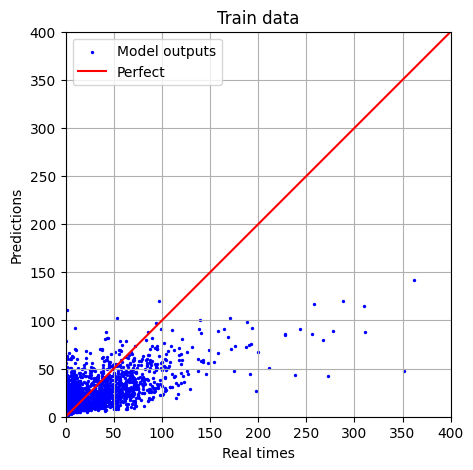

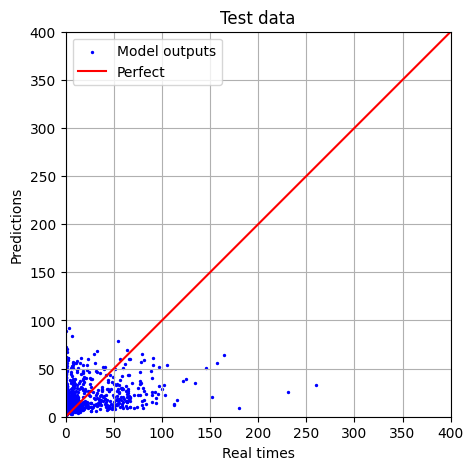

Epochs:  34%|███▍      | 344/1000 [53:52<1:45:02,  9.61s/it]

Epochs:  35%|███▌      | 350/1000 [54:49<1:44:46,  9.67s/it]

Train Loss: 3570.513428
Test MSE = 4254.63134765625
Test L1 = 54.367618560791016
Test R2 = -5.3652238845825195
Test MAPE = 185.687744140625
Test Spearman = 0.5179751515388489
--------------------------------------------------------------------------------


Epochs:  36%|███▌      | 360/1000 [56:22<1:41:35,  9.52s/it]

Train Loss: 28122.851562
Test MSE = 29223.431640625
Test L1 = 150.85838317871094
Test R2 = -42.72028350830078
Test MAPE = 465.0503234863281
Test Spearman = 0.5421011447906494
--------------------------------------------------------------------------------


Epochs:  37%|███▋      | 370/1000 [57:54<1:39:36,  9.49s/it]

Train Loss: 74077.203125
Test MSE = 75848.8046875
Test L1 = 255.50942993164062
Test R2 = -112.47508239746094
Test MAPE = 897.5139770507812
Test Spearman = 0.5552462935447693
--------------------------------------------------------------------------------


Epochs:  37%|███▋      | 371/1000 [58:04<1:39:18,  9.47s/it]

New best: 372, Train Loss: 219.266907
Test MSE = 589.5191650390625
Test L1 = 9.218344688415527
Test R2 = 0.1180383563041687
Test MAPE = 14.005478858947754
Test Spearman = 0.5521501898765564


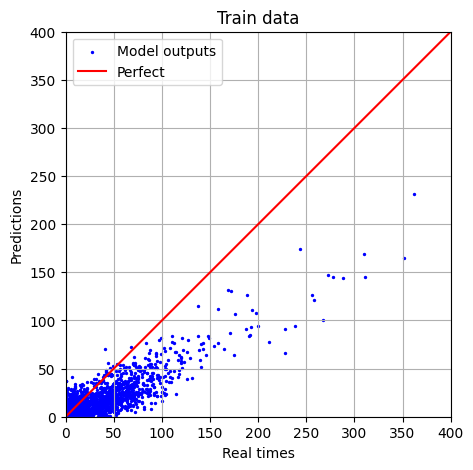

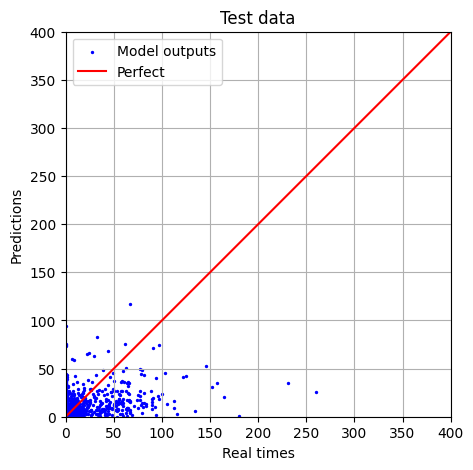

Epochs:  37%|███▋      | 372/1000 [58:15<1:43:47,  9.92s/it]

Epochs:  38%|███▊      | 380/1000 [59:30<1:39:29,  9.63s/it]

Train Loss: 15467.396484
Test MSE = 16707.7421875
Test L1 = 108.38274383544922
Test R2 = -23.995943069458008
Test MAPE = 305.312744140625
Test Spearman = 0.5803412795066833
--------------------------------------------------------------------------------


Epochs:  39%|███▉      | 390/1000 [1:01:04<1:37:36,  9.60s/it]

Train Loss: 644.252258
Test MSE = 729.7160034179688
Test L1 = 18.30792236328125
Test R2 = -0.0917057991027832
Test MAPE = 85.8948745727539
Test Spearman = 0.2691720724105835
--------------------------------------------------------------------------------


Epochs:  40%|████      | 400/1000 [1:02:37<1:35:37,  9.56s/it]

Train Loss: 94848.421875
Test MSE = 97655.2109375
Test L1 = 293.03485107421875
Test R2 = -145.09898376464844
Test MAPE = 1058.937744140625
Test Spearman = 0.54484623670578
--------------------------------------------------------------------------------


Epochs:  41%|████      | 410/1000 [1:04:14<1:37:42,  9.94s/it]

Train Loss: 6158.636230
Test MSE = 6620.232421875
Test L1 = 70.26145935058594
Test R2 = -8.904327392578125
Test MAPE = 224.70555114746094
Test Spearman = 0.5901345014572144
--------------------------------------------------------------------------------


Epochs:  42%|████▏     | 420/1000 [1:05:49<1:34:20,  9.76s/it]

Train Loss: 7171.173340
Test MSE = 7929.369140625
Test L1 = 68.9094467163086
Test R2 = -10.862887382507324
Test MAPE = 166.0915069580078
Test Spearman = 0.5550073981285095
--------------------------------------------------------------------------------


Epochs:  43%|████▎     | 430/1000 [1:07:23<1:31:26,  9.63s/it]

Train Loss: 6479.878418
Test MSE = 7018.67333984375
Test L1 = 60.946842193603516
Test R2 = -9.500422477722168
Test MAPE = 115.42215728759766
Test Spearman = 0.5809447765350342
--------------------------------------------------------------------------------


Epochs:  44%|████▍     | 440/1000 [1:08:57<1:30:30,  9.70s/it]

Train Loss: 4676.899414
Test MSE = 5385.4345703125
Test L1 = 57.47671890258789
Test R2 = -7.056983947753906
Test MAPE = 155.77508544921875
Test Spearman = 0.5586586594581604
--------------------------------------------------------------------------------


Epochs:  45%|████▌     | 450/1000 [1:10:31<1:27:39,  9.56s/it]

Train Loss: 23829.875000
Test MSE = 24792.841796875
Test L1 = 139.4196014404297
Test R2 = -36.09181594848633
Test MAPE = 420.8795166015625
Test Spearman = 0.5855118036270142
--------------------------------------------------------------------------------


Epochs:  46%|████▌     | 460/1000 [1:12:04<1:26:06,  9.57s/it]

Train Loss: 8330.861328
Test MSE = 9228.7392578125
Test L1 = 72.91474151611328
Test R2 = -12.806835174560547
Test MAPE = 165.50717163085938
Test Spearman = 0.5493705868721008
--------------------------------------------------------------------------------


Epochs:  46%|████▋     | 465/1000 [1:12:50<1:23:08,  9.33s/it]

New best: 466, Train Loss: 172.281540
Test MSE = 611.3236694335938
Test L1 = 11.474326133728027
Test R2 = 0.08541727066040039
Test MAPE = 25.82778549194336
Test Spearman = 0.5587555170059204


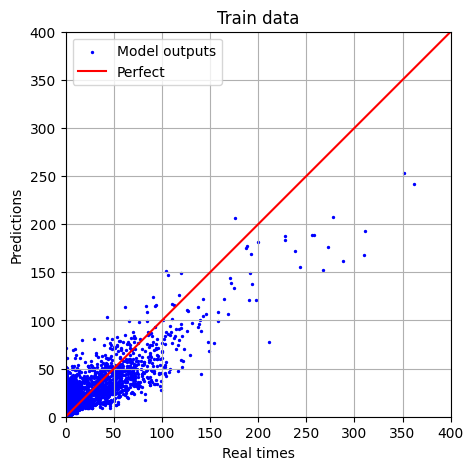

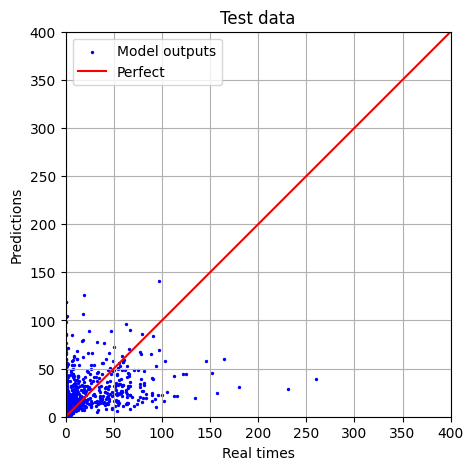

Epochs:  47%|████▋     | 466/1000 [1:13:01<1:28:03,  9.89s/it]

Epochs:  47%|████▋     | 470/1000 [1:13:40<1:26:31,  9.79s/it]

Train Loss: 28542.849609
Test MSE = 30079.0234375
Test L1 = 156.1363067626953
Test R2 = -44.000308990478516
Test MAPE = 473.77325439453125
Test Spearman = 0.5890539884567261
--------------------------------------------------------------------------------


Epochs:  47%|████▋     | 473/1000 [1:14:08<1:23:48,  9.54s/it]

New best: 474, Train Loss: 168.402725
Test MSE = 608.0669555664062
Test L1 = 10.60712718963623
Test R2 = 0.09028959274291992
Test MAPE = 14.76363754272461
Test Spearman = 0.4626539647579193


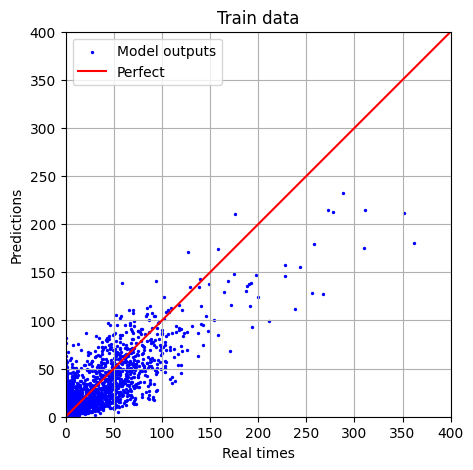

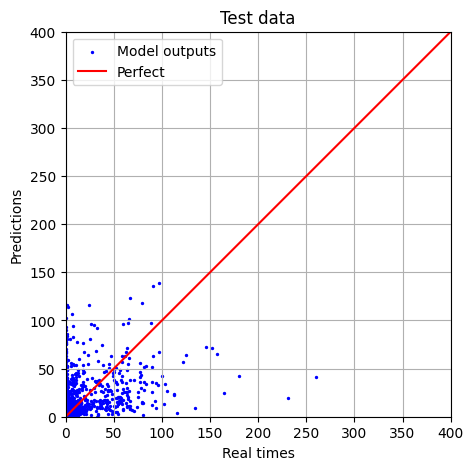

Epochs:  47%|████▋     | 474/1000 [1:14:19<1:26:32,  9.87s/it]

Epochs:  48%|████▊     | 480/1000 [1:15:17<1:25:21,  9.85s/it]

Train Loss: 41926.941406
Test MSE = 44368.8359375
Test L1 = 189.3507843017578
Test R2 = -65.37886047363281
Test MAPE = 604.0787963867188
Test Spearman = 0.5611256957054138
--------------------------------------------------------------------------------


Epochs:  49%|████▉     | 490/1000 [1:16:50<1:20:26,  9.46s/it]

Train Loss: 576.946838
Test MSE = 884.9696044921875
Test L1 = 21.2639102935791
Test R2 = -0.3239760398864746
Test MAPE = 75.73701477050781
Test Spearman = 0.5869171619415283
--------------------------------------------------------------------------------


Epochs:  50%|█████     | 500/1000 [1:18:23<1:19:49,  9.58s/it]

Train Loss: 264.958588
Test MSE = 606.6984252929688
Test L1 = 13.167155265808105
Test R2 = 0.09233695268630981
Test MAPE = 44.70838928222656
Test Spearman = 0.5614792108535767
--------------------------------------------------------------------------------


Epochs:  51%|█████     | 510/1000 [1:19:57<1:18:02,  9.56s/it]

Train Loss: 32455.455078
Test MSE = 33431.265625
Test L1 = 160.555419921875
Test R2 = -49.01549530029297
Test MAPE = 464.60595703125
Test Spearman = 0.5751627683639526
--------------------------------------------------------------------------------


Epochs:  52%|█████▏    | 520/1000 [1:21:30<1:16:53,  9.61s/it]

Train Loss: 751.878906
Test MSE = 1216.8382568359375
Test L1 = 21.233537673950195
Test R2 = -0.8204745054244995
Test MAPE = 50.93627166748047
Test Spearman = 0.5712106227874756
--------------------------------------------------------------------------------


Epochs:  53%|█████▎    | 530/1000 [1:23:04<1:15:15,  9.61s/it]

Train Loss: 43710.851562
Test MSE = 45703.37890625
Test L1 = 188.63858032226562
Test R2 = -67.37542724609375
Test MAPE = 551.3026733398438
Test Spearman = 0.576469898223877
--------------------------------------------------------------------------------


Epochs:  54%|█████▍    | 540/1000 [1:24:38<1:13:56,  9.64s/it]

Train Loss: 262.067474
Test MSE = 612.5424194335938
Test L1 = 12.744291305541992
Test R2 = 0.08359390497207642
Test MAPE = 27.956735610961914
Test Spearman = 0.5796375870704651
--------------------------------------------------------------------------------


Epochs:  55%|█████▌    | 550/1000 [1:26:12<1:12:07,  9.62s/it]

Train Loss: 54228.886719
Test MSE = 56145.75390625
Test L1 = 215.49559020996094
Test R2 = -82.9979476928711
Test MAPE = 710.949462890625
Test Spearman = 0.554033100605011
--------------------------------------------------------------------------------


Epochs:  56%|█████▌    | 560/1000 [1:27:47<1:10:44,  9.65s/it]

Train Loss: 213.119202
Test MSE = 723.4766235351562
Test L1 = 13.437700271606445
Test R2 = -0.08237135410308838
Test MAPE = 25.578033447265625
Test Spearman = 0.48572131991386414
--------------------------------------------------------------------------------


Epochs:  57%|█████▋    | 570/1000 [1:29:20<1:08:06,  9.50s/it]

Train Loss: 903.615662
Test MSE = 1493.8486328125
Test L1 = 21.97014617919922
Test R2 = -1.2349014282226562
Test MAPE = 37.451656341552734
Test Spearman = 0.5558499693870544
--------------------------------------------------------------------------------


Epochs:  58%|█████▊    | 580/1000 [1:30:53<1:06:50,  9.55s/it]

Train Loss: 944.142151
Test MSE = 1350.6402587890625
Test L1 = 22.52574348449707
Test R2 = -1.0206515789031982
Test MAPE = 54.923439025878906
Test Spearman = 0.5298592448234558
--------------------------------------------------------------------------------


Epochs:  59%|█████▉    | 590/1000 [1:32:27<1:05:18,  9.56s/it]

Train Loss: 413.707611
Test MSE = 611.1846923828125
Test L1 = 14.642557144165039
Test R2 = 0.0856252908706665
Test MAPE = 37.357086181640625
Test Spearman = 0.5631195902824402
--------------------------------------------------------------------------------


Epochs:  60%|██████    | 600/1000 [1:33:59<1:03:32,  9.53s/it]

Train Loss: 526.689697
Test MSE = 622.0997924804688
Test L1 = 14.328326225280762
Test R2 = 0.06929546594619751
Test MAPE = 51.17325973510742
Test Spearman = 0.48884111642837524
--------------------------------------------------------------------------------


Epochs:  61%|██████    | 610/1000 [1:35:34<1:03:25,  9.76s/it]

Train Loss: 3911.430176
Test MSE = 4622.29345703125
Test L1 = 48.809539794921875
Test R2 = -5.9152727127075195
Test MAPE = 98.7072525024414
Test Spearman = 0.5608438849449158
--------------------------------------------------------------------------------


Epochs:  62%|██████▏   | 620/1000 [1:37:09<1:01:52,  9.77s/it]

Train Loss: 415.473633
Test MSE = 590.3661499023438
Test L1 = 12.614741325378418
Test R2 = 0.1167711615562439
Test MAPE = 40.8608512878418
Test Spearman = 0.45988544821739197
--------------------------------------------------------------------------------


Epochs:  63%|██████▎   | 630/1000 [1:38:43<59:21,  9.63s/it]  

Train Loss: 340.419312
Test MSE = 571.2534790039062
Test L1 = 9.6190185546875
Test R2 = 0.14536511898040771
Test MAPE = 15.041597366333008
Test Spearman = 0.5409684777259827
--------------------------------------------------------------------------------


Epochs:  64%|██████▍   | 640/1000 [1:40:18<58:10,  9.70s/it]

Train Loss: 658.634888
Test MSE = 750.9096069335938
Test L1 = 12.685955047607422
Test R2 = -0.12341296672821045
Test MAPE = 38.33066940307617
Test Spearman = 0.525460958480835
--------------------------------------------------------------------------------


Epochs:  65%|██████▌   | 650/1000 [1:41:53<56:42,  9.72s/it]

Train Loss: 374.832275
Test MSE = 741.0513916015625
Test L1 = 14.958479881286621
Test R2 = -0.10866439342498779
Test MAPE = 33.13158416748047
Test Spearman = 0.5369160771369934
--------------------------------------------------------------------------------


Epochs:  66%|██████▌   | 660/1000 [1:43:26<54:17,  9.58s/it]

Train Loss: 67055.351562
Test MSE = 69149.0546875
Test L1 = 238.5801239013672
Test R2 = -102.45179748535156
Test MAPE = 691.205810546875
Test Spearman = 0.5962659120559692
--------------------------------------------------------------------------------


Epochs:  67%|██████▋   | 670/1000 [1:45:00<53:11,  9.67s/it]

Train Loss: 22220.419922
Test MSE = 23311.337890625
Test L1 = 126.80422973632812
Test R2 = -33.87538146972656
Test MAPE = 267.2041320800781
Test Spearman = 0.6030007004737854
--------------------------------------------------------------------------------


Epochs:  68%|██████▊   | 680/1000 [1:46:34<51:27,  9.65s/it]

Train Loss: 10529.230469
Test MSE = 11583.9638671875
Test L1 = 80.57572937011719
Test R2 = -16.330415725708008
Test MAPE = 160.93923950195312
Test Spearman = 0.5785945057868958
--------------------------------------------------------------------------------


Epochs:  69%|██████▉   | 690/1000 [1:48:07<49:08,  9.51s/it]

Train Loss: 3136.667480
Test MSE = 3822.545166015625
Test L1 = 42.4227294921875
Test R2 = -4.7187933921813965
Test MAPE = 76.29215240478516
Test Spearman = 0.5853237509727478
--------------------------------------------------------------------------------


Epochs:  70%|███████   | 700/1000 [1:49:42<48:29,  9.70s/it]

Train Loss: 1627.416748
Test MSE = 2323.233642578125
Test L1 = 35.54523849487305
Test R2 = -2.4757189750671387
Test MAPE = 110.24950408935547
Test Spearman = 0.554517924785614
--------------------------------------------------------------------------------


Epochs:  70%|███████   | 703/1000 [1:50:11<47:15,  9.55s/it]

New best: 704, Train Loss: 132.734451
Test MSE = 728.565673828125
Test L1 = 12.950244903564453
Test R2 = -0.08998489379882812
Test MAPE = 29.862131118774414
Test Spearman = 0.49745407700538635


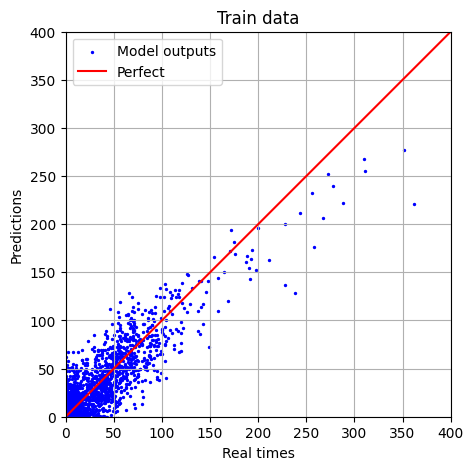

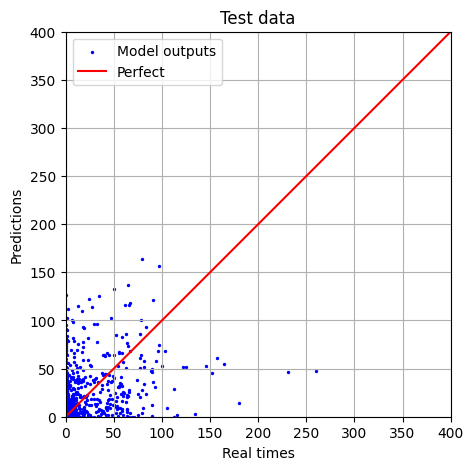

Epochs:  70%|███████   | 704/1000 [1:50:21<48:40,  9.87s/it]

Epochs:  71%|███████   | 710/1000 [1:51:18<47:27,  9.82s/it]

Train Loss: 2973.802002
Test MSE = 3664.393798828125
Test L1 = 43.42826843261719
Test R2 = -4.482187747955322
Test MAPE = 91.47086334228516
Test Spearman = 0.5821409225463867
--------------------------------------------------------------------------------


Epochs:  72%|███████▏  | 720/1000 [1:52:53<44:50,  9.61s/it]

Train Loss: 57943.160156
Test MSE = 60372.22265625
Test L1 = 220.9951171875
Test R2 = -89.32103729248047
Test MAPE = 710.3804321289062
Test Spearman = 0.5614223480224609
--------------------------------------------------------------------------------


Epochs:  73%|███████▎  | 730/1000 [1:54:26<42:19,  9.41s/it]

Train Loss: 27707.222656
Test MSE = 29369.892578125
Test L1 = 142.57769775390625
Test R2 = -42.93939971923828
Test MAPE = 317.6510925292969
Test Spearman = 0.5893149971961975
--------------------------------------------------------------------------------
New best: 731, Train Loss: 88.468346
Test MSE = 584.6602783203125
Test L1 = 10.952157974243164
Test R2 = 0.12530755996704102
Test MAPE = 23.015628814697266
Test Spearman = 0.5124622583389282


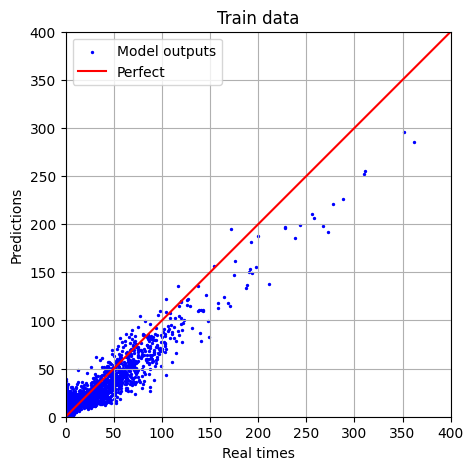

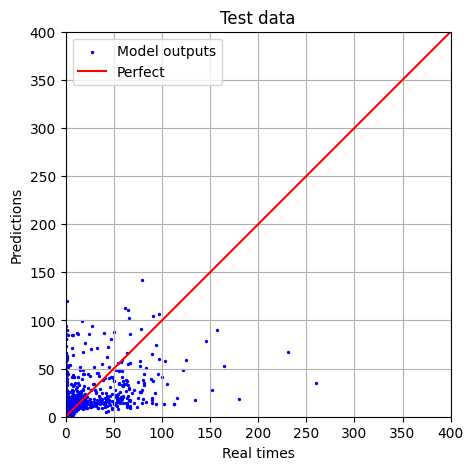

Epochs:  73%|███████▎  | 731/1000 [1:54:36<43:55,  9.80s/it]

Epochs:  74%|███████▍  | 740/1000 [1:56:03<42:49,  9.88s/it]

Train Loss: 484.871338
Test MSE = 568.78955078125
Test L1 = 11.613420486450195
Test R2 = 0.1490512490272522
Test MAPE = 30.353824615478516
Test Spearman = 0.46534064412117004
--------------------------------------------------------------------------------


Epochs:  75%|███████▌  | 750/1000 [1:57:37<40:02,  9.61s/it]

Train Loss: 2964.798828
Test MSE = 3837.407470703125
Test L1 = 40.11776351928711
Test R2 = -4.741028308868408
Test MAPE = 64.17076873779297
Test Spearman = 0.5773916840553284
--------------------------------------------------------------------------------


Epochs:  76%|███████▌  | 760/1000 [1:59:10<38:09,  9.54s/it]

Train Loss: 507.726288
Test MSE = 856.179443359375
Test L1 = 21.094907760620117
Test R2 = -0.2809039354324341
Test MAPE = 85.6343994140625
Test Spearman = 0.5270066261291504
--------------------------------------------------------------------------------


Epochs:  77%|███████▋  | 770/1000 [2:00:44<36:53,  9.62s/it]

Train Loss: 6683.124512
Test MSE = 7559.58837890625
Test L1 = 69.9897232055664
Test R2 = -10.309669494628906
Test MAPE = 198.0310821533203
Test Spearman = 0.5683177709579468
--------------------------------------------------------------------------------


Epochs:  78%|███████▊  | 780/1000 [2:02:19<35:42,  9.74s/it]

Train Loss: 82268.945312
Test MSE = 85142.1171875
Test L1 = 265.3725891113281
Test R2 = -126.37852478027344
Test MAPE = 846.319580078125
Test Spearman = 0.566138744354248
--------------------------------------------------------------------------------


Epochs:  79%|███████▉  | 790/1000 [2:03:52<33:16,  9.51s/it]

Train Loss: 1909.338623
Test MSE = 2598.743408203125
Test L1 = 39.79121780395508
Test R2 = -2.8879008293151855
Test MAPE = 139.179931640625
Test Spearman = 0.5479512214660645
--------------------------------------------------------------------------------


Epochs:  80%|████████  | 800/1000 [2:05:25<31:55,  9.58s/it]

Train Loss: 8559.856445
Test MSE = 9336.4921875
Test L1 = 73.7983169555664
Test R2 = -12.96804141998291
Test MAPE = 151.7281951904297
Test Spearman = 0.5627337694168091
--------------------------------------------------------------------------------


Epochs:  81%|████████  | 810/1000 [2:06:58<30:07,  9.51s/it]

Train Loss: 458.283783
Test MSE = 643.7981567382812
Test L1 = 16.991207122802734
Test R2 = 0.03683316707611084
Test MAPE = 59.898590087890625
Test Spearman = 0.5676147937774658
--------------------------------------------------------------------------------


Epochs:  82%|████████▏ | 820/1000 [2:08:31<28:37,  9.54s/it]

Train Loss: 1643.392212
Test MSE = 1730.8682861328125
Test L1 = 38.02154541015625
Test R2 = -1.5894992351531982
Test MAPE = 193.34938049316406
Test Spearman = 0.5566580295562744
--------------------------------------------------------------------------------


Epochs:  83%|████████▎ | 830/1000 [2:10:04<27:10,  9.59s/it]

Train Loss: 1510.414673
Test MSE = 2242.359375
Test L1 = 29.87201690673828
Test R2 = -2.3547253608703613
Test MAPE = 71.18578338623047
Test Spearman = 0.5087475776672363
--------------------------------------------------------------------------------


Epochs:  84%|████████▍ | 840/1000 [2:11:38<25:37,  9.61s/it]

Train Loss: 63275.410156
Test MSE = 65126.70703125
Test L1 = 231.46401977539062
Test R2 = -96.43408203125
Test MAPE = 667.3692016601562
Test Spearman = 0.6069548726081848
--------------------------------------------------------------------------------


Epochs:  85%|████████▌ | 850/1000 [2:13:11<23:51,  9.54s/it]

Train Loss: 27745.351562
Test MSE = 29271.189453125
Test L1 = 147.8553009033203
Test R2 = -42.79173278808594
Test MAPE = 416.4698181152344
Test Spearman = 0.5810028910636902
--------------------------------------------------------------------------------


Epochs:  86%|████████▌ | 860/1000 [2:14:45<22:22,  9.59s/it]

Train Loss: 4579.719238
Test MSE = 4786.47119140625
Test L1 = 57.77981948852539
Test R2 = -6.160893440246582
Test MAPE = 191.92369079589844
Test Spearman = 0.5453509092330933
--------------------------------------------------------------------------------


Epochs:  87%|████████▋ | 870/1000 [2:16:18<20:37,  9.52s/it]

Train Loss: 1210.999268
Test MSE = 1386.9012451171875
Test L1 = 30.953697204589844
Test R2 = -1.0749006271362305
Test MAPE = 115.3869857788086
Test Spearman = 0.568265974521637
--------------------------------------------------------------------------------


Epochs:  88%|████████▊ | 880/1000 [2:17:51<19:06,  9.55s/it]

Train Loss: 32059.527344
Test MSE = 33446.7421875
Test L1 = 155.429931640625
Test R2 = -49.03865051269531
Test MAPE = 404.1188049316406
Test Spearman = 0.5791671872138977
--------------------------------------------------------------------------------


Epochs:  89%|████████▉ | 890/1000 [2:19:24<17:35,  9.59s/it]

Train Loss: 2847.711182
Test MSE = 3313.166748046875
Test L1 = 41.22148132324219
Test R2 = -3.9567275047302246
Test MAPE = 92.87178802490234
Test Spearman = 0.5543307065963745
--------------------------------------------------------------------------------


Epochs:  90%|█████████ | 900/1000 [2:20:57<15:48,  9.48s/it]

Train Loss: 2801.423828
Test MSE = 3509.18310546875
Test L1 = 40.76213073730469
Test R2 = -4.249981880187988
Test MAPE = 84.37503051757812
Test Spearman = 0.5733788013458252
--------------------------------------------------------------------------------


Epochs:  91%|█████████ | 910/1000 [2:22:30<14:19,  9.55s/it]

Train Loss: 11004.142578
Test MSE = 11846.794921875
Test L1 = 94.22305297851562
Test R2 = -16.723628997802734
Test MAPE = 300.75140380859375
Test Spearman = 0.558437705039978
--------------------------------------------------------------------------------


Epochs:  92%|█████████▏| 920/1000 [2:24:03<12:42,  9.53s/it]

Train Loss: 21220.609375
Test MSE = 22221.12890625
Test L1 = 129.4073486328125
Test R2 = -32.244354248046875
Test MAPE = 394.85150146484375
Test Spearman = 0.5569458603858948
--------------------------------------------------------------------------------


Epochs:  93%|█████████▎| 930/1000 [2:25:35<10:40,  9.15s/it]

Train Loss: 104566.546875
Test MSE = 107266.2734375
Test L1 = 301.2196044921875
Test R2 = -159.47779846191406
Test MAPE = 912.6676025390625
Test Spearman = 0.6148146986961365
--------------------------------------------------------------------------------


Epochs:  94%|█████████▍| 940/1000 [2:27:03<09:04,  9.07s/it]

Train Loss: 17205.373047
Test MSE = 18035.48046875
Test L1 = 112.82626342773438
Test R2 = -25.982332229614258
Test MAPE = 270.2503662109375
Test Spearman = 0.5896099805831909
--------------------------------------------------------------------------------


Epochs:  95%|█████████▌| 950/1000 [2:28:30<07:28,  8.98s/it]

Train Loss: 13135.043945
Test MSE = 14331.9873046875
Test L1 = 103.49617004394531
Test R2 = -20.441648483276367
Test MAPE = 324.7751770019531
Test Spearman = 0.5781535506248474
--------------------------------------------------------------------------------


Epochs:  96%|█████████▌| 960/1000 [2:29:58<05:58,  8.97s/it]

Train Loss: 6343.074707
Test MSE = 7444.34326171875
Test L1 = 68.23933410644531
Test R2 = -10.13725471496582
Test MAPE = 192.59432983398438
Test Spearman = 0.5531297922134399
--------------------------------------------------------------------------------


Epochs:  97%|█████████▋| 970/1000 [2:31:25<04:30,  9.01s/it]

Train Loss: 1021.648743
Test MSE = 1206.263427734375
Test L1 = 27.353076934814453
Test R2 = -0.8046540021896362
Test MAPE = 91.50440216064453
Test Spearman = 0.5569571256637573
--------------------------------------------------------------------------------


Epochs:  98%|█████████▊| 980/1000 [2:32:53<03:00,  9.05s/it]

Train Loss: 8141.999512
Test MSE = 8815.7685546875
Test L1 = 73.7697982788086
Test R2 = -12.189002990722656
Test MAPE = 174.45416259765625
Test Spearman = 0.5842562913894653
--------------------------------------------------------------------------------


Epochs:  99%|█████████▉| 990/1000 [2:34:20<01:29,  8.96s/it]

Train Loss: 379.016052
Test MSE = 570.2127075195312
Test L1 = 11.962167739868164
Test R2 = 0.14692211151123047
Test MAPE = 24.208681106567383
Test Spearman = 0.5418363213539124
--------------------------------------------------------------------------------


Epochs: 100%|██████████| 1000/1000 [2:35:47<00:00,  9.35s/it]

Train Loss: 16739.933594
Test MSE = 17942.26171875
Test L1 = 112.7076644897461
Test R2 = -25.842870712280273
Test MAPE = 289.3656005859375
Test Spearman = 0.5925630331039429
--------------------------------------------------------------------------------
Best result is 88.46834564208984 at 731


Test MSE = 584.66015625
Test L1 = 10.952156066894531
Test R2 = 0.12530773878097534
Test MAPE = 23.015626907348633
Test Spearman = 0.5124650001525879
Best result is 88.46834564208984 at 731


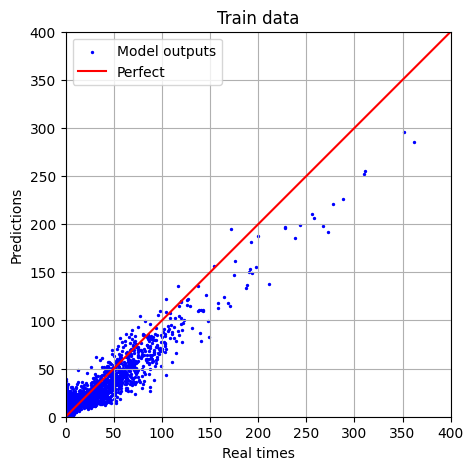

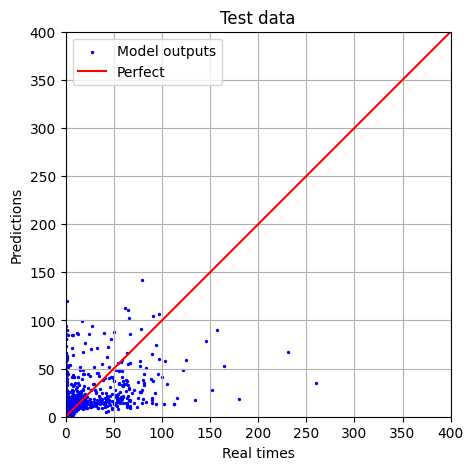

In [ ]:
torch.manual_seed(12345)
random.seed(12345)
numpy.random.seed(12345)

# Initialize model 
model = HeteroGNN(hidden_dim=config['embedding']).to(DEVICE) 
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
if config['target'] == "sat":
    criterion = torch.nn.BCELoss() # only 2 classes 
else:
    criterion = torch.nn.MSELoss() 


# Save model configuration 
timestamp = int(time.time()) 
os.mkdir(f"logs/{timestamp}")
with open(f"logs/{timestamp}/config.txt", 'w') as f:
    for key in config:
        f.write(f'{key}={config[key]}\n') 

# Before training (evaluate initial random model)
train_out, train_y = test(train_loader) 
test_out, test_y = test(test_loader) 
# Return to linear-space 
if config['log']:
    train_out = torch.exp(train_out)
    train_y = torch.exp(train_y)
    test_out = torch.exp(test_out)
    test_y = torch.exp(test_y) 

train_loss = compute_main_metric(train_out, train_y) 
metrics = compute_metrics(test_out, test_y) 
for metric in metrics:
    print(f'Test {metric} = {metrics[metric]}') 

# Store in files 
with open(f"logs/{timestamp}/init-metrics.txt", 'w') as f:
    for metric in metrics:
        f.write(f'Test {metric} = {metrics[metric]}\n') 
    if config['target'] == 'seconds':
        # For regression
        f.write(f"{train_loss} & {metrics['MSE']} & {metrics['L1']} & {metrics['R2']} & {metrics['MAPE']} & {metrics['Spearman']}\n")
plot_predictions(train_out, train_y, title='Train data', file=f'logs/{timestamp}/init-train.png') 
plot_predictions(test_out, test_y, title='Test data', file=f'logs/{timestamp}/init-test.png') 




# Actual training 
best_loss = 1e10 
best_epoch = 0 
best_model = deepcopy(model) 
history = {}
for epoch in tqdm(range(1, config['epochs']+1), desc='Epochs'): 
    train() 
    train_out, train_y = test(train_loader) 
    train_loss = compute_main_metric(train_out, train_y) 

    # Save best model so far 
    if train_loss < best_loss:
        best_loss = train_loss 
        best_model = deepcopy(model) 
        best_epoch = epoch 

        print(f'New best: {epoch:03d}, Train Loss: {train_loss:.6f}') 

        test_out, test_y = test(test_loader) 
        # Return to linear-space 
        if config['log']:
            train_out = torch.exp(train_out)
            train_y = torch.exp(train_y)
            test_out = torch.exp(test_out)
            test_y = torch.exp(test_y) 

        metrics = compute_metrics(test_out, test_y) 
        for metric in metrics:
            print(f'Test {metric} = {metrics[metric]}') 
        
        plot_predictions(train_out, train_y, title='Train data') 
        plot_predictions(test_out, test_y, title='Test data') 
        print() # Empty line 

        history[epoch] = {
            "train_loss": train_loss.cpu().item()
        }
        history[epoch].update({ k: metrics[k].cpu().item() for k in metrics }) 
        

    if epoch % 10 == 0:
        test_out, test_y = test(test_loader) 
        metrics = compute_metrics(test_out, test_y) 
        print(f'Train Loss: {train_loss:.6f}') 
        for metric in metrics:
            print(f'Test {metric} = {metrics[metric]}') 
        print("-"*80)

print(f"Best result is {best_loss} at {best_epoch}") 



# After training
model = best_model # Evaluate the best model 
train_out, train_y = test(train_loader) 
test_out, test_y = test(test_loader) 
# Return to linear-space 
if config['log']:
    train_out = torch.exp(train_out)
    train_y = torch.exp(train_y)
    test_out = torch.exp(test_out)
    test_y = torch.exp(test_y) 

train_loss = compute_main_metric(train_out, train_y) 
metrics = compute_metrics(test_out, test_y) 
for metric in metrics:
    print(f'Test {metric} = {metrics[metric]}') 

# Store in files 
with open(f"logs/{timestamp}/metrics.txt", 'w') as f:
    f.write(f"Train loss: {train_loss} at {best_epoch}\n")
    for metric in metrics:
        f.write(f'Test {metric} = {metrics[metric]}\n') 
    if config['target'] == 'seconds':
        # For regression 
        f.write(f"{best_epoch} & {train_loss} & {metrics['MSE']} & {metrics['L1']} & {metrics['R2']} & {metrics['MAPE']} & {metrics['Spearman']}\n")
plot_predictions(train_out, train_y, title='Train data', file=f'logs/{timestamp}/train.png') 
plot_predictions(test_out, test_y, title='Test data', file=f'logs/{timestamp}/test.png') 

with open(f"logs/{timestamp}/architecture.txt", 'w') as f:
    for batch in train_loader:
        batch.batch = {'literals': compute_batch_assignment(batch, 'literals'), 'clauses': compute_batch_assignment(batch, 'clauses')} 
        batch = batch.to(DEVICE)
        f.write(summary(model, batch, max_depth=5)) 
        break 
# Store best model 
torch.save(best_model, f"logs/{timestamp}/model.pt") 


t_end = int(time.time()) 
with open(f"logs/{timestamp}/time.txt", 'w') as f:
    f.write(f"{t_end - timestamp}") # in seconds

df_history = pd.DataFrame([history[k] for k in sorted(history.keys())], index=sorted(history.keys())) 
df_history.to_csv(f"logs/{timestamp}/history.csv", index_label="Epoch") 

print(f"Best result is {best_loss} at {best_epoch}")